# Import

In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from typing import List, Union
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import datetime
import matplotlib.pyplot as plt

# Config

In [6]:
config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'base_path': '../open (1)', # change relative path of data
    'train_data': 'zeroto20.csv', # change train data csv name
    'test_data': 'test20.csv', # change test data csv name
    'seed': 42,
    'valid_size': 0.1,
    'early_stopping': 20,
    'scheduler': True,
    'train' : {
       'batch_size' : 16,
       'num_workers': 1,
       'epochs': 100,
       'lr': 0.001,
    },
    'inference' : {
       'batch_size' : 8,
       'num_workers': 1,
       'threshold': 0.35,
    },
}

custom_transform = {
    'train':A.Compose([
        A.augmentations.crops.transforms.RandomCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'valid':A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'test': A.Compose([
        A.Normalize(),
        ToTensorV2()
    ]),
}

# Utils

In [11]:
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# RLE 디코딩 함수
def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# dice score 계산 함수
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

def calculate_dice_scores(validation_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''
    # Extract the mask_rle columns
    pred_mask_rle = validation_df.iloc[:, 3]
    gt_mask_rle = validation_df.iloc[:, 4]

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)
        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None
    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )
    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values
    return np.mean(dice_scores)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# Train
- 1024 * 1024 * 3 이미지 학습

### load train data

In [ ]:
# Colab 사용시 활성화

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Colab 사용시 활성화

# colab_base = '/content/drive/MyDrive/open'# 구글드라이브에서 데이터를 저장한 경로로 바꾸세요.
# train_df = pd.read_csv(f"{colab_base}/{config['train_data']}")
# train_df['img_path'] = colab_base + train_df['img_path'].str[1:]
# train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
# print("train: ", len(train), "   valid: ", len(val))

In [ ]:
# kaggle 사용시 활성화

# train_df = pd.read_csv('/kaggle/input/swdacon/train.csv')
# train_df['img_path'] = '/kaggle/input/swdacon/' + train_df['img_path'].str[1:]
# train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
# print("train: ", len(train), "   valid: ", len(val))

In [4]:
train_df = pd.read_csv(f"{config['base_path']}/{config['train_data']}")
train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
print("train: ", len(train), "   valid: ", len(val))

train:  14    valid:  6


### Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_rles = None, transform=None, infer=False):
        self.img_paths = img_paths
        self.mask_rles = mask_rles
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.mask_rles.iloc[idx]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

### Data Loader

In [6]:
fix_seed(config['seed'])

train_dataset = CustomDataset(img_paths=train['img_path'], mask_rles=train['mask_rle'], transform=custom_transform['train'])
train_dataloader = DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

valid_dataset = CustomDataset(img_paths=val['img_path'], mask_rles=val['mask_rle'], transform=custom_transform['valid'])
valid_dataloader = DataLoader(valid_dataset , batch_size=config['train']['batch_size'], shuffle=False, num_workers=config['train']['num_workers'])

### Model

In [7]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        x = self.dconv_down4(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Validation

In [8]:
def validation(config, model, criterion, valid_loader, val):
    model.eval()
    valid_loss = 0
    result = []
    transformed_mask = []
    val_df = val.copy()

    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            if type(transformed_mask) == torch.Tensor:
                transformed_mask = torch.cat([transformed_mask, masks])
            else:
                transformed_mask = masks.clone().detach()
            images = images.float().to(config['device'])
            masks = masks.float().to(config['device'])

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            valid_loss += loss.item()

            output_masks = torch.sigmoid(outputs).cpu().numpy()
            output_masks = np.squeeze(output_masks, axis=1)
            output_masks = (output_masks > config['inference']['threshold']).astype(np.uint8)

            for i in range(len(images)):
                mask_rle = rle_encode(output_masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
        val_df['valid_mask_rle'] = result
        val_df['transformed_mask_rle'] = list(map(rle_encode, transformed_mask.squeeze().numpy()))
        dice_score = calculate_dice_scores(val_df)

    return valid_loss/len(valid_loader), dice_score

### Train

In [9]:
def training(config, model, train_loader, valid_loader, val):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None

    criterion = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-8, verbose=True)

    # training loop
    for epoch in range(config['train']['epochs']):
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(train_loader):
            images = images.float().to(config['device'])
            masks = masks.float().to(config['device'])

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        val_loss, dice_score = validation(config, model, criterion, valid_loader, val)
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            best_epoch = epoch
            print(f"Epoch [{epoch + 1}] New Minimum Valid Loss!")
            
        if config['scheduler']:
            scheduler.step(val_loss)

        if es_count == config['early_stopping']:
            print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Dice Coefficient: {dice_score:6f}, ES Count: {es_count}')
            print(f"EARLY STOPPING COUNT에 도달했습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model

        print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Dice Coefficient: {dice_score:6f} ES Count: {es_count}')
        print("------------------------------------------------------------------------------------")

    print(f"EARLY STOPPING COUNT에 도달하지 않았습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [10]:
best_model = training(config, UNet(), train_dataloader, valid_dataloader, val)

  0%|          | 0/4 [00:00<?, ?it/s]

## Inference
- 224 * 224 * 3 이미지 추론

### load test data

In [ ]:
# Colab 사용시 활성화

# test_df = pd.read_csv(f"{colab_base}/{config['test_data']}")
# test_df['img_path'] = colab_base + test_df['img_path'].str[1:]

In [ ]:
# kaggle 사용시 활성화

# test_df = pd.read_csv('/kaggle/input/swdacon/test.csv')
# test_df['img_path'] = '/kaggle/input/swdacon/' + test_df['img_path'].str[1:]

In [9]:
test_df = pd.read_csv(f"{config['base_path']}/{config['test_data']}")

### Data Loader

In [18]:
fix_seed(config['seed'])

test_dataset = CustomDataset(img_paths=test_df['img_path'], transform=custom_transform['test'], infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['inference']['batch_size'], shuffle=False, num_workers=config['inference']['num_workers'])

In [8]:
def inference(config, model, test_loader):
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_loader):
            images = images.float().to(config['device'])
            
            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > config['inference']['threshold']).astype(np.uint8)
            
            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
    return result

100% 3790/3790 [04:18<00:00, 14.65it/s]


In [ ]:
inference_result = inference(config, best_model, test_dataloader)

## Submission

In [ ]:
# Colab 사용시 활성화

# submit = pd.read_csv(f"{colab_base}/submit20.csv")
# submit['mask_rle'] = inference_result

# now = datetime.datetime.now()
# current_time = now.strftime("%m%d-%H:%M:%S")
# file_name = f"{current_time}.csv"

# submit.to_csv(f"{colab_base}/{file_name}", index=False)

In [ ]:
# kaggle 사용시 활성화

# submit = pd.read_csv(f"/kaggle/input/swdacon/sample_submission.csv")
# submit['mask_rle'] = inference_result

# now = datetime.datetime.now()
# current_time = now.strftime("%m%d-%H:%M:%S")
# file_name = f"{current_time}.csv"

# submit.to_csv(f"/kaggle/working/{file_name}", index=False)

In [ ]:
submit = pd.read_csv(f"{config['base_path']}/sample_submission.csv")
submit['mask_rle'] = inference_result

now = datetime.datetime.now()
current_time = now.strftime("%m%d-%H:%M:%S")
file_name = f"{current_time}.csv"

submit.to_csv(f"{config['base_path']}/{file_name}", index=False)

# Submission Viewer
- 방금 생성한 csv 파일의 결과를 눈으로 보기

In [7]:
def submission_viewer(test_csv, submit_csv, img_num, base_path = config['base_path'], is_colab = False):
    """
    white -> 건물 black -> 배경
    1. Local에서 사용 시 test_csv, submit_csv, img_num만 입력
    2. colab에서 사용 시 아래 사항을 입력
    base_path = colab_base
    is_colab = True
    """
    mask_rle = submit_csv.iloc[img_num, 1]
    image_path = test_csv.iloc[img_num, 1]
    if is_colab:
        image = cv2.imread(image_path)
    else:
        image = cv2.imread(base_path + image_path[1:])
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax1.set_title('image')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask,cmap='gray')
    ax2.set_title('mask')
    plt.show()

In [ ]:
# Colab 사용시 활성화
# last_submit = pd.read_csv(f"{colab_base}/{file_name}")
# submission_viewer(test_df, last_submit, 0, colab_base, is_colab = True)
# submission_viewer(test_df, last_submit, 1, colab_base, is_colab = True)
# submission_viewer(test_df, last_submit, 2, colab_base, is_colab = True)

In [ ]:
# kaggle 사용시 활성화
# last_submit = pd.read_csv(f"/kaggle/working/{file_name}")
# submission_viewer(test_df, last_submit, 0, f'/kaggle/working/{file_name}', is_colab = True)
# submission_viewer(test_df, last_submit, 1, f'/kaggle/working/{file_name}', is_colab = True)
# submission_viewer(test_df, last_submit, 2, f'/kaggle/working/{file_name}', is_colab = True)

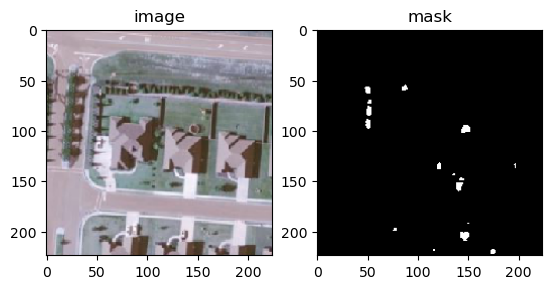

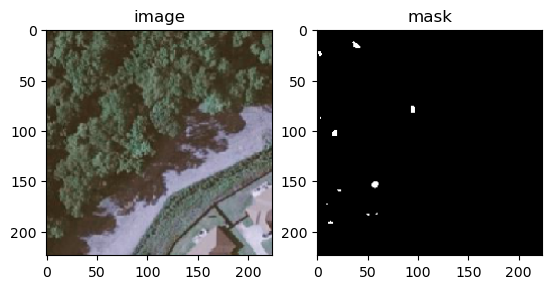

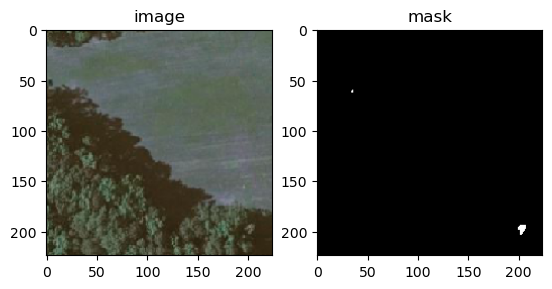

In [13]:
last_submit = pd.read_csv(f"../open (1)/baseline (1).csv")
submission_viewer(test_df, last_submit, 0) # 보고 싶은 test 번호로 변경
submission_viewer(test_df, last_submit, 1)
submission_viewer(test_df, last_submit, 2)